In [2]:
import numpy as np
import pandas as pd
import scanpy as sc 

adata = sc.read_h5ad("dataset_co_mo.h5ad")
#lr_genes = pd.read_csv("dataset_co_mo.csv", header=0)  # Or header=True if you're on an older pandas version

In [19]:
adata

AnnData object with n_obs × n_vars = 7890 × 13123
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'

In [20]:
adata.obs['BatchID']

AAACCCACAGTGCCTG-1    Cancer Cells (Co)
AAACCCAGTGTTCCTC-1    Cancer Cells (Co)
AAACGAAGTGTTGAGG-1    Cancer Cells (Co)
AAACGCTAGGGAGAAT-1    Cancer Cells (Co)
AAACGCTCAGAGTGAC-1    Cancer Cells (Co)
                            ...        
TTTGATCGTACGTTCA-1    Cancer Cells (Mo)
TTTGATCTCCTACAAG-1    Cancer Cells (Mo)
TTTGGAGAGGCTCAAG-1    Cancer Cells (Mo)
TTTGGTTTCTGGCCGA-1    Cancer Cells (Mo)
TTTGTTGCATACACCA-1    Cancer Cells (Mo)
Name: BatchID, Length: 7890, dtype: category
Categories (4, object): ['Cancer Cells (Co)', 'Cancer Cells (Mo)', 'Fibroblasts (Co)', 'Fibroblasts (Mo)']

In [22]:
# Extract source and receiver genes efficiently
gl_source = ['TGFBR2', 'SMAD3', 'HIF1A', 'PDGFB'] # All values from the first column
gl_recv =['TGFB1', 'IL6', 'PDGFRB']  # All values from the second column

ict1 = adata.obs["BatchID"] == "Cancer Cells (Co)"
ict2 = adata.obs["BatchID"] == "Fibroblasts (Co)" 
adata_ct1 = adata[ict1, gl_source]
adata_ct2 = adata[ict2, gl_recv]
print(adata_ct1)
print(adata_ct2)

View of AnnData object with n_obs × n_vars = 1414 × 4
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
View of AnnData object with n_obs × n_vars = 1324 × 3
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'


In [25]:
Xct1 = adata_ct1.X.copy()
Xct2 = adata_ct2.X.copy()
Xct1 = Xct1.toarray()
Xct2 = Xct2.toarray()
# Compute cell percentace of cell type 1 count matrix
Xct1p = np.sum(Xct1>0, axis=0)/len(Xct1[:,0])
Xct2p = np.sum(Xct2>0, axis=0)/len(Xct2[:,0])

print("CT1 Percentages:", Xct1p)
print("CT2 Percentages:", Xct2p)

CT1 Percentages: [0.3748232  0.79915134 0.88260255 0.29915134]
CT2 Percentages: [0.51812689 0.18806647 0.41993958]


In [28]:
# Scale the data from 0 to 1 to -pi/2 to pi/2
ct1_percentages = (Xct1p-0.5) * np.pi 
ct2_percentages = (Xct2p-0.5) * np.pi

# Display the resulting scaled data
print("Scaled ct1_data:\n", ct1_percentages)
print("Scaled ct2_data:\n", ct2_percentages)

Scaled ct1_data:
 [-0.39325453  0.93981166  1.20198135 -0.63098466]
Scaled ct2_data:
 [ 0.0569473  -0.9799681  -0.25151724]


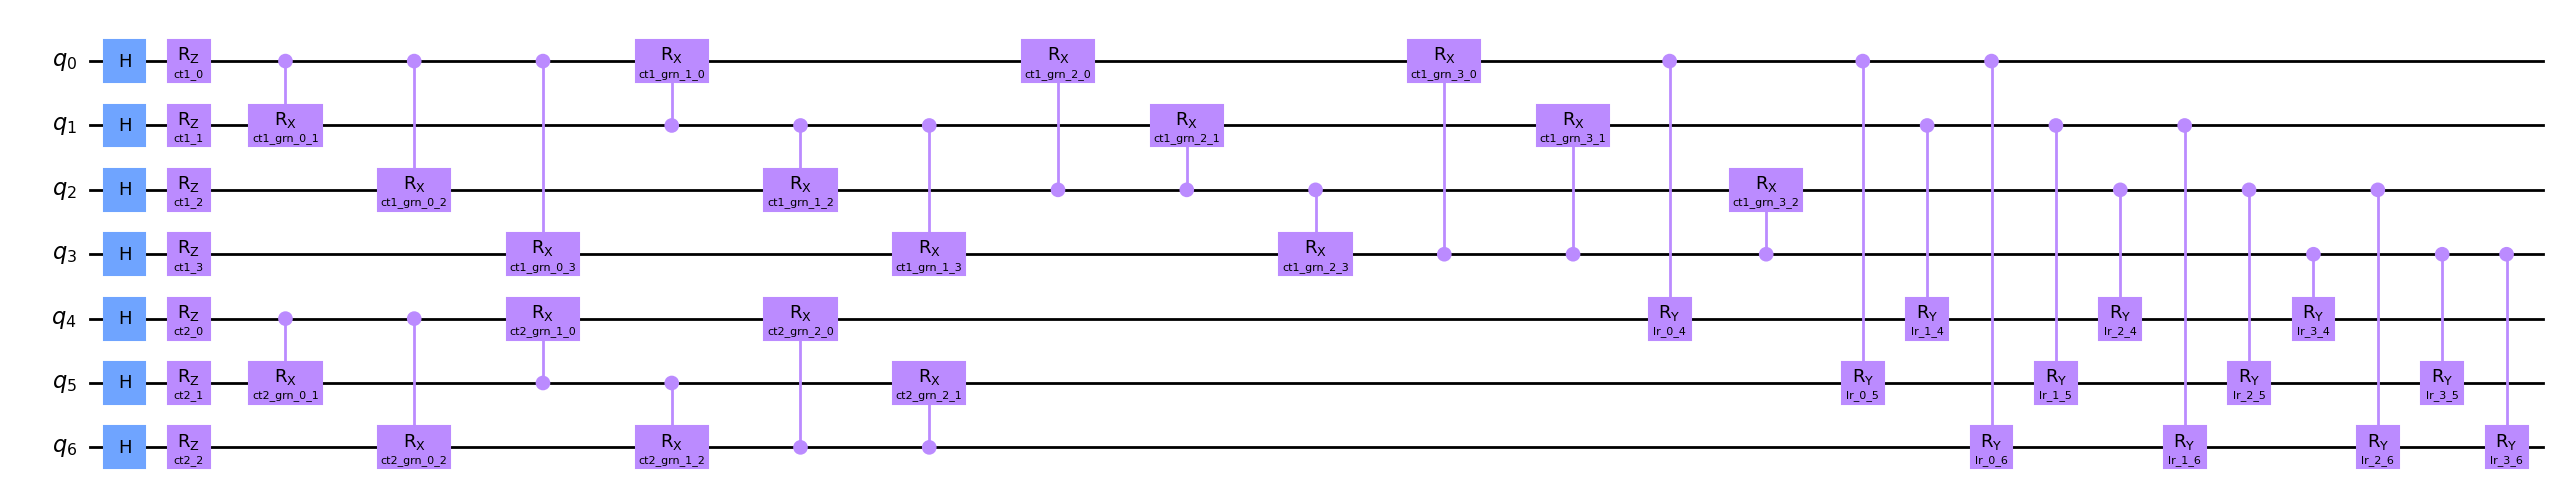

In [29]:
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
import numpy as np

# --- 2. Quantum Circuit Setup (Hadamard Feature Map) ---
ng_ct1 = len(gl_source)
ng_ct2 = len(gl_recv)
num_features = ng_ct1 + ng_ct2

params_ct1 = [Parameter(rf'ct1_{i}') for i in range(ng_ct1)]
params_ct2 = [Parameter(rf'ct2_{i}') for i in range(ng_ct2)]

qc = QuantumCircuit(ng_ct1 + ng_ct2, name="qCellChat_Map")

# Apply Hadamard gates and RY rotations (gene activation probabilities)
for i in range(ng_ct1):
    qc.h(i)
    qc.rz(params_ct1[i], i)

for i in range(ng_ct2):
    qc.h(i + ng_ct1)
    qc.rz(params_ct2[i], i + ng_ct1)

# --- Ansatz circuits ---
ansatz_grn_ct1 = QuantumCircuit(ng_ct1, name="CT1_GRN_Ansatz")
for i in range(ng_ct1):
    for j in range(ng_ct1):
        if i != j:
            param_name = f'ct1_grn_{i}_{j}'
            param = Parameter(param_name)
            ansatz_grn_ct1.crx(param, i, j)

ansatz_grn_ct2 = QuantumCircuit(ng_ct2, name="CT2_GRN_Ansatz")
for i in range(ng_ct2):
    for j in range(ng_ct2):
        if i != j:
            param_name = f'ct2_grn_{i}_{j}'
            param = Parameter(param_name)
            ansatz_grn_ct2.crx(param, i, j)

# --- Combine circuits ---
combined_qc = qc.compose(ansatz_grn_ct1, qubits=range(ng_ct1))
combined_qc = combined_qc.compose(ansatz_grn_ct2, qubits=range(ng_ct1, ng_ct1 + ng_ct2))

# Ligand-receptor interaction ansatz (across cell types)
def generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward"):
    """Generates pairs of qubits for inter-cell interactions."""
    pairs = []
    if direction == "forward":
        for i in range(ng_ct1):
            for j in range(ng_ct2):
                pairs.append([i, j + ng_ct1])  # ct1 to ct2
    elif direction == "backward":
        for i in range(ng_ct2):
            for j in range(ng_ct1):
                pairs.append([j + ng_ct1, i])  # ct2 to ct1  (Corrected offset)
    else:
        raise ValueError("Invalid direction. Must be 'forward' or 'backward'.")
    return pairs

lr_entanglement = generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward")

ansatz_lr = QuantumCircuit(ng_ct1 + ng_ct2, name="LR_Ansatz")  # Create an empty circuit

for pair in lr_entanglement:
    control_qubit = pair[0]  # Access the control qubit index
    target_qubit = pair[1]  # Access the target qubit index
    param_name = rf'lr_{control_qubit}_{target_qubit}'  # Raw f-string for parameter name
    param = Parameter(param_name)
    ansatz_lr.cry(param, control_qubit, target_qubit)

# --- Combine circuits ---
combined_qc = combined_qc.compose(ansatz_lr)

combined_qc.draw(output="mpl", style="clifford", fold=40)

In [626]:
import pandas as pd
from scipy.optimize import minimize
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator  # Or Estimator if using IBM Runtime

# Optimization section
# --- 3. Interaction Strength ---
def create_interaction_observable(lr_entanglement, num_features):
    """Creates a SparsePauliOp observable for interaction strength.
    Args:
        lr_entanglement: A list of qubit pairs representing ligand-receptor interactions.
        num_features: The total number of qubits (across all cell types).
    Returns:
        A SparsePauliOp observable.
    """
    interaction_strength_list = []
    for pair in lr_entanglement:
        qubit1, qubit2 = pair
        pauli_string = ""
        for i in range(num_features):
            if i == qubit1 or i == qubit2:
                pauli_string += "Z"
            else:
                pauli_string += "I"
        interaction_strength_list.append((pauli_string, -1.0))
    # Observable to measure the interaction strength
    interaction_strength = SparsePauliOp.from_list(interaction_strength_list)
    return interaction_strength

def create_interaction_observable_cust(interactions, num_features):
    """Creates a SparsePauliOp observable for custom interactions.
    Args:
        interactions: A dictionary where keys are tuples of node indices 
                      and values are the corresponding interaction strengths.
        num_features: The total number of qubits (across all cell types).
    Returns:
        A SparsePauliOp observable.
    """
    interaction_strength_list = []
    for (node1, node2), strength in interactions.items():
        pauli_string = ""
        for i in range(num_features):
            if i == node1 or i == node2:
                pauli_string += "Z"
            else:
                pauli_string += "I"
        interaction_strength_list.append((pauli_string, strength))

    interaction_observable = SparsePauliOp.from_list(interaction_strength_list)
    return interaction_observable

def cost_func_vqe(params, combined_qc, hamiltonian, estimator):  # combined_qc here
    """Cost function for VQE"""
    bound_qc = combined_qc.assign_parameters(params)  # Assign parameters INSIDE cost_func_vqe
    statevector = Statevector(bound_qc)  # Use bound_qc
    statevector_array = statevector.data
    hamiltonian_matrix = hamiltonian.to_matrix()
    energy = np.real(statevector_array.conjugate() @ hamiltonian_matrix @ statevector_array)
    return energy

def cost_func_wrapper(all_params_values, all_params, combined_qc, interaction_observable, estimator, variable_params):
    for i, param in enumerate(variable_params):
        all_params[param] = all_params_values[i]
    return cost_func_vqe(all_params, combined_qc, interaction_observable, estimator) # Pass combined_qc


In [627]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

estimator = StatevectorEstimator()

# --- Create the FULL parameter dictionary BEFORE optimization ---
def create_parameter_dictionaries(combined_qc, ct1_percentages, ct2_percentages):
    """Creates static and variable parameter dictionaries."""

    # Get Hadamard parameters
    params_ct1 = [param for param in combined_qc.parameters if 'ct1_' in param.name and 'grn' not in param.name and 'lr' not in param.name] #Added conditions
    params_ct2 = [param for param in combined_qc.parameters if 'ct2_' in param.name and 'grn' not in param.name and 'lr' not in param.name] #Added conditions

    static_params = {}
    for i, val in enumerate(ct1_percentages):
        static_params[params_ct1[i]] = val
    for i, val in enumerate(ct2_percentages):
        static_params[params_ct2[i]] = val

    variable_params = [param for param in combined_qc.parameters if param not in static_params]
    return static_params, variable_params


static_params, variable_params = create_parameter_dictionaries(combined_qc, ct1_percentages, ct2_percentages)

print("Static Parameters:", static_params)
print("Variable Parameters:", variable_params)

interaction_observable = create_interaction_observable(lr_entanglement, num_features)
print("Interaction observable: ", interaction_observable)

# Define your custom interactions with strengths
interactions = {
    (0, 0):  -1,
    (0, 1): -1,  
    (0, 2):  -1,
}
interaction_observable = create_interaction_observable_cust(interactions, num_features)
print("Interaction observable custom: ", interaction_observable)



Static Parameters: {Parameter(ct1_0): 1.512378281583516, Parameter(ct2_0): -0.798817026490671, Parameter(ct2_1): -0.5036020384397709}
Variable Parameters: [Parameter(ct2_grn_0_1), Parameter(ct2_grn_1_0), Parameter(lr_0_1), Parameter(lr_0_2)]
Interaction observable:  SparsePauliOp(['ZZI', 'ZIZ'],
              coeffs=[-1.+0.j, -1.+0.j])
Interaction observable custom:  SparsePauliOp(['ZII', 'ZZI', 'ZIZ'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j])


In [628]:
print(gl_recv)
print(gl_source)

['PLAU', 'CD68']
['SPP1']


In [629]:
# Initialize variable parameters
#x0_interaction = np.random.uniform(0, 2*np.pi, len(variable_params))
x0_interaction = np.zeros(len(variable_params))  # All zeros
#x0_interaction = np.full(len(variable_params), np.pi/4)

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params = static_params.copy()  # Start with static parameters
all_params.update(dict(zip(variable_params, x0_interaction)))  # Add variable parameters

# Call minimize with args
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params, combined_qc, interaction_observable, estimator, variable_params), # Pass all the arguments as a tuple
    method="BFGS"
)
print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params, optimized_variable_parameters):
    all_params[param] = value

df = pd.DataFrame(list(all_params.items()), columns=['Parameter', 'Value'])
df_nonzero = df[abs(df.Value) >= 0.01]
print(df_nonzero)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.8032359612981043
        x: [-2.116e+00  4.091e+00  7.337e-01  1.718e+00]
      nit: 20
      jac: [-1.401e-06 -1.095e-06  1.952e-06 -1.475e-06]
 hess_inv: [[ 4.601e+00 -3.540e+00  3.328e-01  1.954e+00]
            [-3.540e+00  8.979e+00 -2.625e+00 -7.951e-01]
            [ 3.328e-01 -2.625e+00  4.093e+00  1.131e+00]
            [ 1.954e+00 -7.951e-01  1.131e+00  4.096e+00]]
     nfev: 115
     njev: 23
     Parameter     Value
0        ct1_0  1.512378
1        ct2_0 -0.798817
2        ct2_1 -0.503602
3  ct2_grn_0_1 -2.116312
4  ct2_grn_1_0  4.091444
5       lr_0_1  0.733722
6       lr_0_2  1.717714


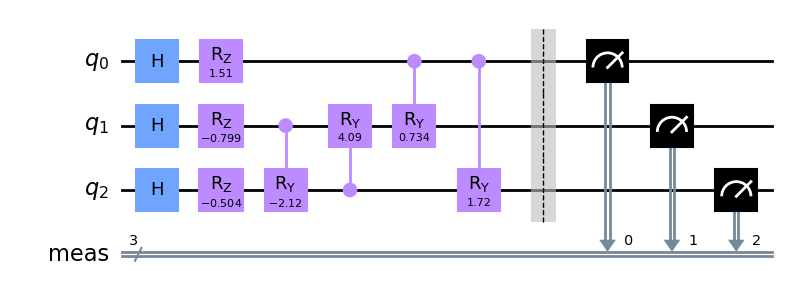

In [630]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
#from qiskit.primitives import SamplerV2  as Sampler  # Import Sampler
#from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Use AerSimulator
sampler = StatevectorSampler()
# Bind the optimized parameters to the circuit
bound_circuit = combined_qc.copy()
bound_circuit.assign_parameters(all_params, inplace=True)
bound_circuit.measure_all() # Add measurement to all the qubits 
bound_circuit.draw(output="mpl", style="clifford", fold=40)

In [631]:
print(gl_source)
print(gl_recv)

['SPP1']
['PLAU', 'CD68']


The number of bitstrings is: 1024
The counts are: {'010': 230, '111': 368, '000': 126, '101': 48, '110': 159, '011': 24, '001': 68, '100': 1}


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_39612\2056871121.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, title="Quantum Sampler Results").show()


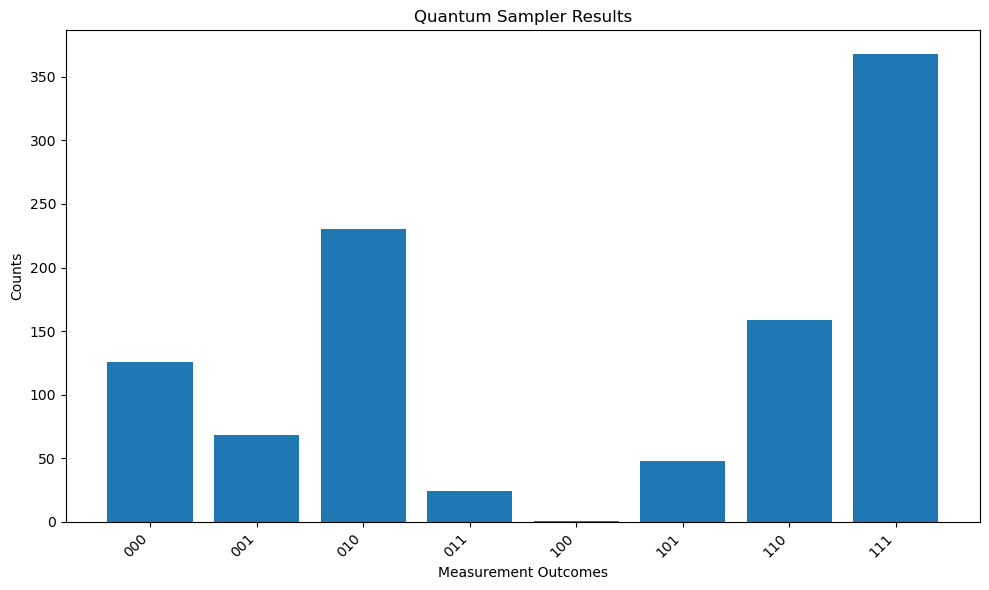

{'010': 230, '111': 368, '000': 126, '101': 48, '110': 159, '011': 24, '001': 68, '100': 1}


In [632]:
# Run the quantum sampler
job = sampler.run( [bound_circuit], shots=1024 )  # Adjust shots as needed
pub_result = job.result()[0]
data_pub = pub_result.data
# Access bitstring for the classical register "meas"
bitstrings = data_pub.meas.get_bitstrings()
print(f"The number of bitstrings is: {len(bitstrings)}")
# Get counts for the classical register "meas"
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")

# Plot the histogram
plot_histogram(counts, title="Quantum Sampler Results").show()

# If you want to use matplotlib directly for more customization
# Convert counts to list for plotting
sorted_counts = dict(sorted(counts.items()))
x_labels = list(sorted_counts.keys())
y_values = list(sorted_counts.values())

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(x_labels, y_values)
plt.xlabel("Measurement Outcomes")
plt.ylabel("Counts")
plt.title("Quantum Sampler Results")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Print the counts
print(counts)